# Boundary values and boundary layer formulations

In [4]:
%load_ext autoreload
%autoreload 2

import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils, pgpy_utils, tools
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Configuration

### Configuration of spectral basis

In [2]:
import models
from operators.polynomials import SphericalHarmonicMode
from operators.worland_transform import WorlandTransform
from operators.associated_legendre_transform import AssociatedLegendreTransformSingleM
from fields import VectorFieldSingleM

nr, maxnl, m_val = 63, 63, 3

model = models.MagnetoCoriolis_Alfven(nr, maxnl, m_val, inviscid=True,
    induction_eq_params={'galerkin': False, 'ideal': False, 'boundary_condition': True})

### Read pre-computed eigenfunctions

In [10]:
eigenvals = list()
eigenvecs = list()
with h5py.File("./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/eigenmodes.h5", 'r') as fread:
    n_gps = len(fread.keys())
    for i_gps in range(n_gps):
        eigenvals.append(fread[f"eigenmode_target{i_gps}"]["eigenvals"][()])
        eigenvecs.append(fread[f"eigenmode_target{i_gps}"]["eigenvecs"][()])

eigeninfo = pd.read_table("./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/eigenspectra_describe.txt", header=3, delimiter='\s+')

if len(eigenvals) == eigeninfo.shape[0]:
    eigeninfo['Calculation'] = [eig_tmp[0] for eig_tmp in eigenvals]
else:
    display(eigenvals)
display(eigeninfo)

,Index,Value,Type,Radial-k[Us(Up-1)],Calculation
0,mdk1,-0.00106348+8.2193247e-5j,unknown,NaN,-0.001063+0.000082j
1,mdk2,-0.00093910+9.2439315e-5j,unknown,NaN,-0.000939+0.000092j
2,mch2,-0.00020907+9.3501762e-5j,columnar-MC?/hybrid,"2,2",-0.000209+0.000094j
3,mch4a,-0.00037579+0.00018705j,columnar-MC?/hybrid,"3,4",-0.000376+0.000187j
4,mch4b,-0.00047235+0.00027038j,columnar-MC?/hybrid,"3,4",-0.000472+0.000270j
5,mn2,-0.00046160+0.00028381j,non-columnar,NaN,-0.000462+0.000284j
6,mch5a,-0.00082576+0.00060796j,columnar-MC?/hybrid,"6,5",-0.000826+0.000608j
7,mch5b,-0.00080937+0.00063396j,columnar-MC?/hybrid,"6,5?",-0.000809+0.000634j
8,mch5c,-0.00111105+0.00093905j,columnar-MC?/hybrid,"5?,5?",-0.001111+0.000939j
9,mch5d,-0.00138856+0.00101398j,columnar-MC?/hybrid,"5?,5?",-0.001389+0.001014j


### Configure evaluation grid

In [12]:
import scipy.special as specfun

# rg = np.linspace(0, 1, 201)
rg = specfun.roots_chebyt(201)[0][101:]
tg = np.linspace(0, np.pi/2, 201)
worland_transform = WorlandTransform(nr, maxnl, m_val, r_grid=rg)
legendre_transform = AssociatedLegendreTransformSingleM(maxnl, m_val, tg)


---
## Boundary evaluation


In [14]:
category_idx = 7
mode_idx = 0

usp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[category_idx][:model.dim['u'], mode_idx])
bsp = VectorFieldSingleM(nr, maxnl, m_val, eigenvecs[category_idx][model.dim['u']:, mode_idx])
norm = np.sqrt(usp.energy)
usp.normalise(norm)
bsp.normalise(norm)

### Evaluate at one meridional slice

In [26]:
uphy_md = usp.physical_field(worland_transform, legendre_transform)
bphy_md = bsp.physical_field(worland_transform, legendre_transform)
longitude = 0

rr, tt = np.meshgrid(uphy_md.grid['r'], uphy_md.grid['theta'])
X1, X2 = rr*np.sin(tt), rr*np.cos(tt)

u_sph = uphy_md.data
u_cyl = {
    's': u_sph['r']*np.sin(tt) + u_sph['theta']*np.cos(tt),
    'phi': u_sph['phi'],
    'z': u_sph['r']*np.cos(tt) - u_sph['theta']*np.sin(tt)
}
b_sph = bphy_md.at_phi(phi=longitude)
b_cyl = {
    's': b_sph['r']*np.sin(tt) + b_sph['theta']*np.cos(tt),
    'phi': b_sph['phi'],
    'z': b_sph['r']*np.cos(tt) - b_sph['theta']*np.sin(tt)
}
fields = {
    'u_r': u_sph['r'], 'u_t': u_sph['theta'],
    'u_s': u_cyl['s'], 'u_p': u_cyl['phi'], 'u_z': u_cyl['z'],
    'b_r': b_sph['r'], 'b_t': b_sph['theta'],
    'b_s': b_cyl['s'], 'b_p': b_cyl['phi'], 'b_z': b_cyl['z'],
}

View meridional plot

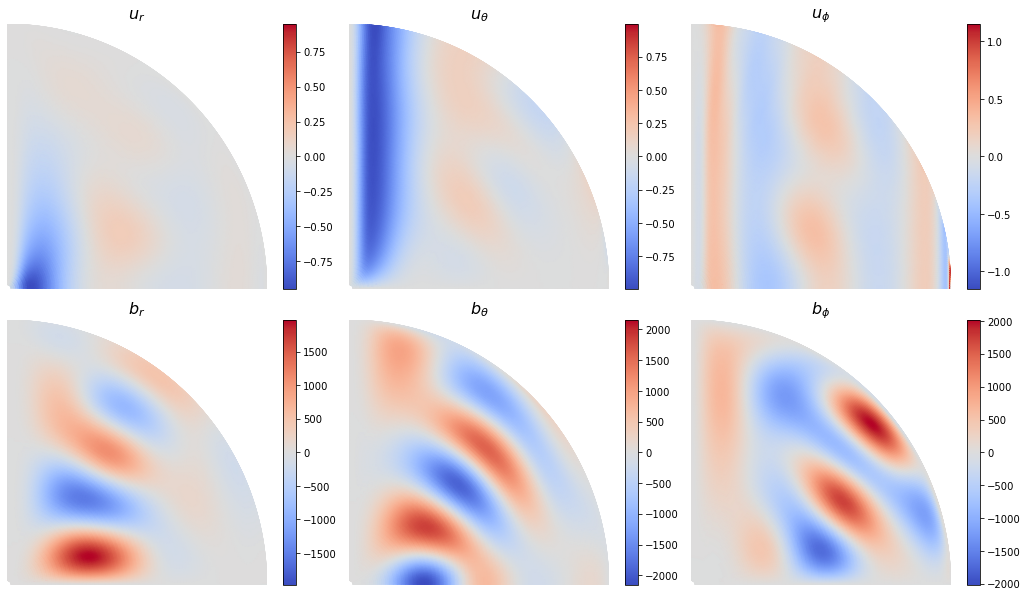

In [27]:
plot_fields = [
    # ["u_s", "u_p", "u_z"],
    ['u_r', 'u_t', 'u_p'],
    ["b_r", "b_t", "b_p"],
]
plot_fnames = [
    # [r"$u_s$", r"$u_\phi$", r"$u_z$"],
    [r"$u_r$", r"$u_\theta$", r"$u_\phi$"],
    [r"$b_r$", r"$b_\theta$", r"$b_\phi$"],
]

# save_name = "./runs/S1pi_Le1e-3_Lu5e+3_m3_parity_oppo/v_md_m3_{:d}".format(category_idx)
# save_name = "./runs/S1pi_Le1e-5_Lu5e+5_m3_parity_oppo/v_md_m3_{}".format(
#     df_view["Index"][category_idx])
# save_name = "./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/v_md_m3_i5"
save_name = None
override = False

force_symmetric_cmap = True

max_u_norm = np.abs(u_sph['r']).max()
# max_u_norm = np.abs(u_cyl['s']).max()
max_b_norm = np.abs(b_sph['r']).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.8, nrows*4.2))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = np.real(fields[fname])
        if np.abs(np.real(field_plot/max_u_norm)).max() > 1e-7:
            # normalizer = max_u_norm if fname[0] == 'u' else max_b_norm
            normalizer = max_u_norm
            if force_symmetric_cmap:
                climit = np.max(np.abs(field_plot/normalizer))
                # climit = np.max(np.abs(field_plot[X1 < 0.5]/normalizer))
                # if i_c == 1:
                #     climit = 1.
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax)
            else:
                cm = ax.pcolormesh(X1, X2, field_plot/normalizer, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax)
        else:
            cm = ax.pcolormesh(X1, X2, field_plot/max_u_norm, vmin=-1e-7, vmax=+1e-7)
            plt.colorbar(cm, ax=ax)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("equal")
        # ax.grid()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

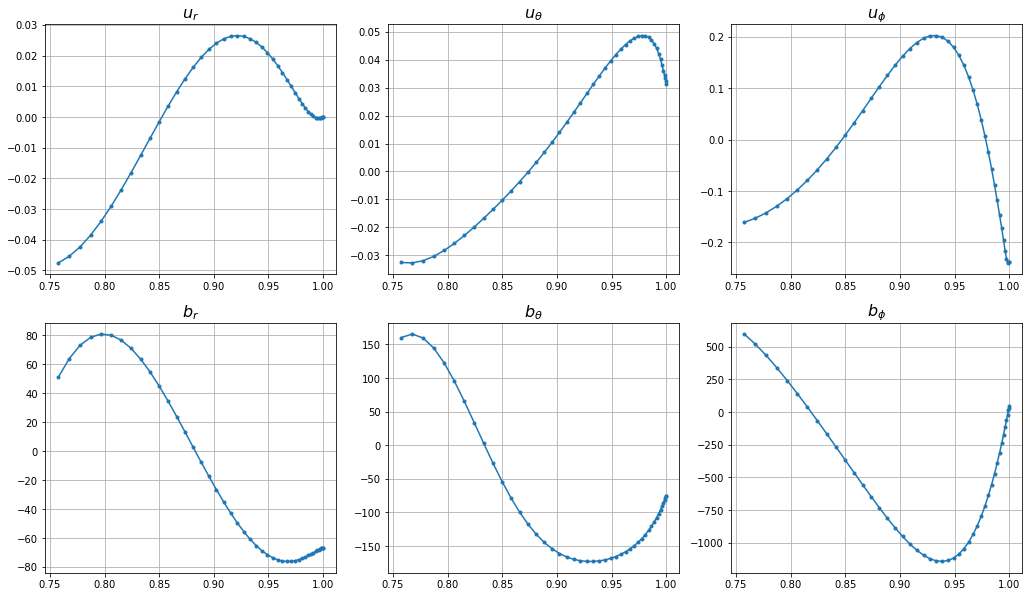

In [39]:
theta_deg = 75
i_tg = np.argmin(np.abs(np.radians(theta_deg) - tg))

r_min = 0.75
i_rg = rg > r_min

plot_fields = [
    # ["u_s", "u_p", "u_z"],
    ['u_r', 'u_t', 'u_p'],
    ["b_r", "b_t", "b_p"],
]
plot_fnames = [
    # [r"$u_s$", r"$u_\phi$", r"$u_z$"],
    [r"$u_r$", r"$u_\theta$", r"$u_\phi$"],
    [r"$b_r$", r"$b_\theta$", r"$b_\phi$"],
]

# save_name = "./runs/S1pi_Le1e-4_Lu2e+4_m1_parity_oppo/v_md_m3_i5"
save_name = None
override = False

force_symmetric_cmap = True

max_u_norm = np.abs(u_sph['r']).max()
# max_u_norm = np.abs(u_cyl['s']).max()
max_b_norm = np.abs(b_sph['r']).max()

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4.8, nrows*4.2))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = np.real(fields[fname][i_tg, :])
        ax.plot(rg[i_rg], field_plot[i_rg], '.-')
        ax.grid(which='both')
        # if np.abs(np.real(field_plot/max_u_norm)).max() < 1e-7:
        #     ax.set_ylim([-1e-7, +1e-7])
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        # ax.axis("off")

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()